In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import io
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage
import toml
import glob
import h5py
from tqdm.auto import tqdm
from markovids import vid
from scipy import spatial, signal, ndimage
import sleap_io

In [3]:
from qd_analysis.fig import setup_plotting_env

In [4]:
from joblib import Parallel, delayed
import pandas as pd
import seaborn as sns

In [5]:
import re
import warnings

In [6]:
import json

In [7]:
config = toml.load("config.toml")
config["dirs"]["analysis"]

'/home/jmarkow/data_dir/active_projects/quantum_dots/_analysis'

In [54]:
from scipy.stats import rankdata

def rank_biserial_correlation(x, y):
    differences = np.array(x) - np.array(y)
    non_zero_differences = differences[differences != 0]
    ranks = rankdata(np.abs(non_zero_differences))
    
    # Step 4: Get the sum of ranks for positive and negative differences
    w_plus = np.sum(ranks[non_zero_differences > 0])   # Sum of ranks for positive differences
    w_minus = np.sum(ranks[non_zero_differences < 0])  # Sum of ranks for negative differences
    
    # Step 5: Calculate rank-biserial correlation
    # n = len(non_zero_differences)
    n = len(non_zero_differences)
    total_ranks_sum = n * (n + 1) / 2 # number of pairs
    rank_biserial = (w_plus - w_minus) / total_ranks_sum
    
    return rank_biserial

In [8]:
# https://stackoverflow.com/questions/66171969/compute-center-of-mass-in-numpy
def center_of_mass(array: np.ndarray, yidx = None, xidx = None):
    total = array.sum()
    # alternatively with np.arange as well
    if yidx is None:
        yidx = range(array.shape[0])

    if xidx is None:
        xidx = range(array.shape[1])
    
    y_coord = (array.sum(axis=1) @ yidx) / total
    x_coord = (array.sum(axis=0) @ xidx) / total
    return x_coord, y_coord

In [9]:
save_dir = "/mnt/data/jmarkow/panels/2024-06 (QD paper)"
os.makedirs(save_dir, exist_ok=True)

## Gather data and predicted keypoints

In [10]:
# pool repeats

In [11]:
model_dirs = [
    "/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_fused_v2_04/models/unet_filters-64_filters_rate-2_training_labels-train_frames_fused_weights-None_bpass-None.slp_repeat-0.single_instance/",
    "/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_fused_v2_04/models/unet_filters-64_filters_rate-2_training_labels-train_frames_fused_weights-None_bpass-None.slp_repeat-1.single_instance/",
    "/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_fused_v2_04/models/unet_filters-64_filters_rate-2_training_labels-train_frames_fused_weights-None_bpass-None.slp_repeat-2.single_instance/",
    "/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_fused_v2_04/models/unet_filters-64_filters_rate-2_training_labels-train_frames_fused_weights-None_bpass-None.slp_repeat-3.single_instance/",
    "/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_fused_v2_04/models/unet_filters-64_filters_rate-2_training_labels-train_frames_fused_weights-None_bpass-None.slp_repeat-4.single_instance/",
    
]
# fluo_files = sorted(glob.glob(os.path.join(base_dir, "**", "Basler*fluorescence.avi"), recursive=True))

In [12]:
save_file = os.path.join(config["dirs"]["analysis"], "kpoint_qd_gt_comparison.parquet") 

In [13]:
dcts = []
search_radius = 7.5

search_obj = skimage.morphology.disk(radius=search_radius).astype("float")
search_y, search_x = np.where(search_obj>0)
center = search_obj.shape[0] // 2
xx = np.arange(search_obj.shape[1] + 1)
yy = np.arange(search_obj.shape[0] + 1)
xx -= center
yy -= center

In [14]:
if not os.path.exists(save_file):
    for count_model, _model_dir in tqdm(enumerate(model_dirs), total=len(model_dirs)):
        with open(os.path.join(_model_dir, "training_config.json")) as f:
            training_config = json.load(f)
        
        training_data_path = os.path.join(_model_dir, "../../", training_config["data"]["labels"]["training_labels"])
        training_metadata_path = os.path.splitext(training_data_path)[0] + ".toml"
        training_metadata = toml.load(training_metadata_path)["segments_metadata"]
        
        _dset = sleap_io.load_slp(os.path.join(_model_dir, "labels_gt.train.slp"))
        skeleton = _dset.skeleton
    
        # dset = sleap_io.load_slp(training_data_path)
        training_gt_dset = sleap_io.load_slp(os.path.join(_model_dir, "labels_gt.train.slp")).labeled_frames
        training_pred_dset = sleap_io.load_slp(os.path.join(_model_dir, "labels_pr.train.slp")).labeled_frames
        validation_gt_dset = sleap_io.load_slp(os.path.join(_model_dir, "labels_gt.val.slp")).labeled_frames
        validation_pred_dset = sleap_io.load_slp(os.path.join(_model_dir, "labels_pr.val.slp")).labeled_frames
        
        concat_gt_dset = training_gt_dset + validation_gt_dset
        concat_pred_dset = training_pred_dset + validation_pred_dset
        
        use_metadata = [training_metadata[i] for i in training_config["data"]["labels"]["training_inds"]]
        use_metadata += [training_metadata[i] for i in training_config["data"]["labels"]["validation_inds"]]
        
        fluo_fnames = sorted(list(set([_metadata["dat_path_fluo"] for _metadata in use_metadata])))
        
        all_bgrounds = {}
        for _fname in tqdm(fluo_fnames):
            bground_fname = os.path.join(
                os.path.dirname(_fname),
                "_bground",
                os.path.splitext(os.path.basename(_fname))[0] + ".hdf5",
            )
            all_bgrounds[_fname] = {}
            with h5py.File(bground_fname, "r") as f:
                all_bgrounds[_fname]["bgrounds"] = f["bground"][()]
                all_bgrounds[_fname]["idxs"] = f["frame_idxs"][()]
    
       
        for count, (labeled_frame_gt, labeled_frame_pred, metadata) in tqdm(
            enumerate(zip(concat_gt_dset, concat_pred_dset, use_metadata)), total=len(use_metadata)
        ):
            points_gt = labeled_frame_gt.instances[0].points
            points_pred = labeled_frame_pred.instances[0].points
            bgrounds = all_bgrounds[metadata["dat_path_fluo"]]["bgrounds"]
            bgrounds_idxs = all_bgrounds[metadata["dat_path_fluo"]]["idxs"]
        
            reader = vid.io.AutoReader(metadata["dat_path_fluo"])
            width, height = reader.frame_size
            frame = reader.get_frames(metadata["frame_index"])[0]
            reader.close()
            use_bground_idx = np.argmin(np.abs(bgrounds_idxs - metadata["frame_index"]))
            bground_sub = np.clip(frame.astype("int16") - bgrounds[use_bground_idx], 0, np.inf)
            is_train = labeled_frame_pred.frame_idx in training_config["data"]["labels"]["training_inds"]
            # bground_sub[bground_sub<10] = 0
        
            for node, _kpoint in points_pred.items():
                if ~np.isnan(_kpoint.x):
                    # mask out others or remove overlap????
                    gt_x = points_gt[node].x
                    gt_y = points_gt[node].y
        
                    kpoint_x_idx = int(np.round(_kpoint.x))
                    kpoint_y_idx = int(np.round(_kpoint.y))
                    
                    try:
                        new_coords = xx + kpoint_x_idx, yy + kpoint_y_idx
                        xrange = (new_coords[0][0], new_coords[0][-1])
                        yrange = (new_coords[1][0], new_coords[1][-1])
        
                        # get CoM shift relative to center, add as offset to original kpoint
                        masked_bground_sub = search_obj * bground_sub[slice(*yrange), slice(*xrange)].astype("float")
                        com = center_of_mass(masked_bground_sub, yidx=range(*yrange), xidx=range(*xrange))
                        # com = ((_com[0] - center) + _kpoint.x, (_com[1] - center) + _kpoint.y)
                        fluo_ave = np.nanmean(masked_bground_sub[search_y,search_x])
                        fluo_peak = np.nanmax(masked_bground_sub[search_y,search_x])
                        
                    except ValueError:
                        fluo_ave = np.nan
                        fluo_peak = np.nan
                        com = (np.nan, np.nan)
                        peak_loc = (np.nan, np.nan)
                    
                    try:
                        mask = np.zeros_like(bground_sub)
        
                        gt_x_idx = int(np.round(gt_x))
                        gt_y_idx = int(np.round(gt_y))
        
                        new_coords = xx + gt_x_idx, yy + gt_y_idx
                        xrange = (new_coords[0][0], new_coords[0][-1])
                        yrange = (new_coords[1][0], new_coords[1][-1]) 
                        masked_bground_sub = search_obj * bground_sub[slice(*yrange), slice(*xrange)]
                        fluo_ave_gt = np.nanmean(masked_bground_sub[search_y,search_x])
                        fluo_peak_gt = np.nanmax(masked_bground_sub[search_y,search_x])
                    
                    except ValueError:
                        fluo_ave_gt = np.nan
                        fluo_peak_gt = np.nan
                    
        
                    _dct = {
                        "com_x": com[0],
                        "com_y": com[1],
                        "gt_x": gt_x,
                        "gt_y": gt_y,
                        "kpoint_name": node.name,
                        "kpoint_x": _kpoint.x,
                        "kpoint_y": _kpoint.y,
                        "kpoint_to_gt_l2": np.hypot(_kpoint.x - gt_x, _kpoint.y - gt_y),
                        "com_to_gt_l2": np.hypot(com[0] - gt_x, com[1] - gt_y),
                        "fluo_ave": fluo_ave,
                        "fluo_ave_gt": fluo_ave_gt,
                        "fluo_peak": fluo_peak,
                        "fluo_peak_gt": fluo_peak_gt,
                        "frame_index": metadata["frame_index"],
                        "dset_index": count,
                        "model_index": count_model,
                        "dset_type": "train" if is_train else "validate",
                        "model_dir": _model_dir,
                        "search_radius": search_radius,
                    }
        
                    dcts.append(_dct)
    df = pd.DataFrame(dcts)
else:
    df = pd.read_parquet(os.path.join(config["dirs"]["analysis"], "kpoint_qd_gt_comparison.parquet"))

In [15]:
dist_cols = list(df.filter(regex="l2").columns)

In [16]:
threshold = df.query("dset_type == 'train'")["fluo_ave_gt"].quantile(0.01)

In [17]:
df["high_fluo"] = df["fluo_ave"] > threshold

In [18]:
plt_df = (
    df.query("dset_type == 'validate'")
    .groupby(["high_fluo", "model_index", "dset_index"])[dist_cols]
    .mean()
    .melt(ignore_index=False)
    .reset_index()
)

In [19]:
setup_plotting_env()

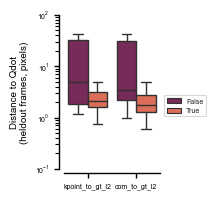

In [20]:
fig, ax = plt.subplots(1, figsize=(1.25, 2.))
sns.boxplot(
    data=plt_df,
    x="variable",
    y="value",
    hue="high_fluo",
    showfliers=False,
    # showcaps=False,
    palette=sns.color_palette("rocket", n_colors=2),
    # clip_on=False,
    # width=.5,
    # dodge=2,
)

ax.legend(bbox_to_anchor=(1,.5))
ax.set_ylabel("Distance to Qdot\n(heldout frames, pixels)")
ax.set_ylim(.1, 100)
ax.set_xlabel("")
ax.set_yscale("log")
sns.despine(offset=3, trim=False)
# fig.savefig(os.path.join(save_dir, "kpoint_qd_gt_error_high_vs_low_fluo.pdf"), bbox_inches="tight")

In [21]:
from scipy.stats import mannwhitneyu, wilcoxon

In [22]:
y1 = plt_df.query("variable == 'kpoint_to_gt_l2' and high_fluo").set_index("dset_index")["value"]
y2 = plt_df.query("variable == 'com_to_gt_l2' and high_fluo").set_index("dset_index")["value"]

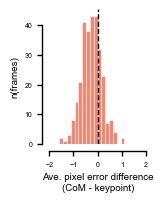

In [23]:
fig, ax = plt.subplots(1, figsize=(1.25,1.75))
sns.histplot((y2-y1), fill=True, color=sns.color_palette("rocket", n_colors=2)[1],
)
ax.set_xlim(-2, 2)
ax.set_xlabel("Ave. pixel error difference\n(CoM - keypoint)")
ax.set_ylabel("n(frames)")
ax.axvline(x=0, lw=1, color="k", ls="--")
sns.despine(offset=5, trim=True)
fig.savefig(os.path.join(save_dir, "kpoint_qd_gt_com_vs_keypoint.pdf"), bbox_inches="tight")

In [24]:
stat_dct = {}

In [25]:
vars = list(plt_df["variable"].unique())

In [59]:
stat_dct["high_v_lo_fluo"] = {}
test = mannwhitneyu
for _var in vars:
    lo_grp = plt_df.query("variable == @_var and not high_fluo")["value"].dropna().values
    hi_grp  = plt_df.query("variable == @_var and high_fluo")["value"].dropna().values
    stat, p = test(hi_grp, lo_grp)
    n1 = len(hi_grp)
    n2 = len(lo_grp)
    stat_dct["high_v_lo_fluo"][_var] = {"p": p, "test": str(test.__name__), "stat": stat, "n1": len(lo_grp), "n2": len(hi_grp), "f": stat / (n1 * n2)}

In [60]:
kpoint_grp = plt_df.query("variable == 'kpoint_to_gt_l2' and high_fluo")["value"].dropna().values
com_grp = plt_df.query("variable == 'com_to_gt_l2' and high_fluo")["value"].dropna().values

In [61]:
stat, p = wilcoxon(kpoint_grp,com_grp) 

In [62]:
stat_dct["kpoint_v_com_hi_fluo"] = {"stat": stat, "p": p, "n1": len(kpoint_grp), "n2": len(com_grp), "r": rank_biserial_correlation(com_grp, kpoint_grp)}

In [63]:
rank_biserial_correlation(com_grp,kpoint_grp)

-0.6391515582414978

In [64]:
with open(os.path.join(save_dir, "kpoint_v_qd_gt.toml"), "w") as f:
    toml.dump(stat_dct, f)

In [ ]:
stat_dct

In [66]:
# df.to_parquet(os.path.join(config["dirs"]["analysis"], "kpoint_qd_gt_comparison.parquet"))

In [67]:
threshold

10.880077519379844

In [68]:
bins = df.query("dset_type == 'train'")["fluo_ave_gt"].quantile(np.linspace(0, 1, 10))

In [69]:
bins

0.000000      2.451085
0.111111     42.094341
0.222222     68.240517
0.333333     94.026667
0.444444    120.067054
0.555556    141.717597
0.666667    168.158837
0.777778    194.124031
0.888889    218.595581
1.000000    253.196899
Name: fluo_ave_gt, dtype: float64

In [70]:
df["fluo_bin"] = pd.cut(df["fluo_ave"], bins, labels=False)

In [71]:
use_mm_per_px = 0.40869886227721863


In [72]:
df["com_to_gt_l2_mm"] = df["com_to_gt_l2"] * use_mm_per_px 

In [ ]:
df.query("dset_type == 'validate' and fluo_ave > 10").groupby(
    ["model_index", "dset_index"]
)["com_to_gt_l2_mm"].median().groupby("model_index").mean().mean()

In [ ]:
.2 / use_mm_per_px

In [ ]:
sns.stripplot(
    data=df.query("dset_type == 'validate'").groupby(["model_index", "fluo_bin", "dset_index"])["com_to_gt_l2_mm"]
    .mean()
    .groupby(["fluo_bin", "model_index"])
    .median()
    .reset_index(),
    x="fluo_bin",
    y="com_to_gt_l2_mm",
)